In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import sqlite3
import re
from scipy import stats

# plot config 

sns.set_style('ticks')
SMALL = 14
MEDIUM = 16
LARGE = 18

# fonts
plt.rc('font', size=SMALL)          # controls default text sizes
plt.rc('axes', titlesize=LARGE, labelsize=MEDIUM)  # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

# axes/tick width
plt.rc('axes', linewidth=2) 
plt.rc('xtick.major', size=10, width=2)
plt.rc('ytick.major', size=10, width=2)
plt.rc('axes.spines', right=False, top=False)

# linewidth
plt.rc('lines', linewidth=2.5, markersize=14)
plt.rc('markers', fillstyle='none')

# see https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
# consider rcparams to override defaults? 
pal = sns.color_palette()
sns.palplot(pal)
blue = sns.color_palette()[0]
orange = sns.color_palette()[1]
red = sns.color_palette()[3]
grey = sns.color_palette()[7]
colors = [blue, orange, red, grey]

# London Marathon EDA
### Author: Elliot Quan

#### Description: literally a notebook of my EDA and plots generated. Will clean up later

#### CTRL+F update to toggle read/write from sqlite database

In [3]:
# helper fxns

def df_selector(df, level, keywords):
    """Utility fxn to select the level and columns to search for a multiindex df.
    keywords must be a list of column names. If the list is length >1, it will perform exact matching.
    """
    if len(keywords) > 1:
        return df.loc[:, df.columns.get_level_values(level).isin(keywords)]
    return df.loc[:, df.columns.get_level_values(level).str.contains(keywords[0])]


def split_format(df, names = None, multi=False):
    """Convert all time columns in df from seconds to timedelta (HH:MM:SS)
    multi denotes MultiIndex columns, which will select split -> mean 
    otherwise, names will expect a list of column names containing split data
    """
    if multi:
        temp = df_selector(df, 0, ['split'])
        temp = df_selector(temp, 1, ['mean'])
        return temp.apply(lambda x: pd.to_timedelta(x, unit='seconds', errors='coerce').dt.round('s'))
    else:
        return df.loc[:, names].apply(lambda x: pd.to_timedelta(x, unit='seconds', errors='coerce').dt.round('s'))


def CoV(x):
    """Coefficient of Variation = sd/mean*100 """
    return np.round(np.std(x)/np.mean(x)*100,1)



In [4]:
con = sqlite3.connect('../nonelite.db')

sql = """
SELECT * FROM nonelite
UNION
SELECT * FROM elite;
"""
df = pd.read_sql_query(sql, con)
con.close()


# 2014-2017 only has a 70+ category, while 2018-2019 have 70-74, etc. so we need to combine those into 70+
df.loc[df['category'].isin(['70-74', '75-79', '80-84']), 'category'] = '70+'


# all dates are read as strings
# convert diff in MM:SS to datetime HH:MM:SS. any missing values are coerced to NaT
df.loc[:, df.columns.str.contains('diff')] = df.loc[:, df.columns.str.contains('diff')].apply(lambda x:
pd.to_datetime(x, format='%M:%S', errors='coerce').dt.time)

# convert all other splits in HH:MM:SS to datetime HH:MM:SS
df.loc[:, df.columns.str.contains('split')] = df.loc[:, df.columns.str.contains('split')].apply(lambda x:
pd.to_datetime(x, format='%H:%M:%S', errors='coerce').dt.time)

# convert everything back to a string...
df.loc[:, df.columns.str.contains('split')] = df.loc[:, df.columns.str.contains('split')].astype(str)

# finally, convert strings to timedelta, then obtain all times in total seconds
df.loc[:, df.columns.str.contains('split')] = df.loc[:, df.columns.str.contains('split')].apply(lambda x:
pd.to_timedelta(x, errors='coerce').dt.total_seconds())

df['split_Half2'] = df['split_Finish'] - df['split_Half']
df['split_25K_diff'] = df['split_Half_diff'] + df['split_25K_diff']
# it is MUCH easier to work with everything in terms of seconds, and then convert back
# to a human readable format after all operations are completed


# for each year and gender, assign a quartile (1,2,3,4) to each runner 
df = df.sort_values(by=['split_Finish'])
df['quartile'] = 1
 
for yr in [2014, 2015, 2016, 2017, 2018, 2019]:
    for g in ['M', 'F']:
        temp = df[(df['year']==yr) & (df['gender']==g)]['split_Finish']
        rank = [temp.quantile(.25), temp.quantile(.5), temp.quantile(.75)]
        df.loc[(df['year']==yr) & (df['gender']==g), 'quartile'] = [1 if time < rank[0] else 2 if time < rank[1] else 3 if time < rank[2] else 4 for time in temp]

# remove country and force lowercase
df['name'] = df['name'].str.replace(' \([A-Z]+\)', '').str.lower()


    
df.loc[:, df.columns.str.contains('split')].head()

,split_5K,split_5K_diff,split_10K,split_10K_diff,split_15K,split_15K_diff,split_20K,split_20K_diff,split_Half,split_Half_diff,...,split_25K_diff,split_30K,split_30K_diff,split_35K,split_35K_diff,split_40K,split_40K_diff,split_Finish,split_Finish_diff,split_Half2
110919,863.0,863.0,1741.0,879.0,2622.0,882.0,3505.0,883.0,3697.0,192.0,...,854.0,5224.0,867.0,6115.0,892.0,6980.0,866.0,7357.0,378.0,3660.0
73295,863.0,863.0,1742.0,879.0,2622.0,881.0,3505.0,883.0,3697.0,192.0,...,854.0,5224.0,866.0,6115.0,892.0,6982.0,867.0,7375.0,393.0,3678.0
115477,856.0,856.0,1717.0,861.0,2597.0,881.0,3490.0,894.0,3684.0,194.0,...,870.0,5233.0,875.0,6127.0,894.0,7009.0,883.0,7385.0,377.0,3701.0
214097,863.0,863.0,1742.0,879.0,2623.0,881.0,3505.0,883.0,3697.0,192.0,...,857.0,5224.0,863.0,6116.0,892.0,6989.0,873.0,7396.0,408.0,3699.0
18360,856.0,856.0,1717.0,861.0,2597.0,881.0,3491.0,894.0,3684.0,194.0,...,870.0,5233.0,874.0,6127.0,894.0,7018.0,892.0,7431.0,413.0,3747.0


In [5]:
df.shape

(234613, 33)

In [6]:
df.columns

Index(['name', 'country', 'club', 'category', 'id', 'place_gender',
       'place_category', 'place_overall', 'gender', 'elite', 'split_5K',
       'split_5K_diff', 'split_10K', 'split_10K_diff', 'split_15K',
       'split_15K_diff', 'split_20K', 'split_20K_diff', 'split_Half',
       'split_Half_diff', 'split_25K', 'split_25K_diff', 'split_30K',
       'split_30K_diff', 'split_35K', 'split_35K_diff', 'split_40K',
       'split_40K_diff', 'split_Finish', 'split_Finish_diff', 'year',
       'split_Half2', 'quartile'],
      dtype='object')

In [7]:
# For 2019 runners: mark runners who ran at least once in 2014-2018
# default type none, T/F only for 2019 runners
# of course this is imperfect, but it is better than nothing


df['repeat'] = None
df['cat_int'] = df['category'].factorize()[0] # convert cat to numeric labels 0-7

# convert 3 fields (name, country, category as int) into a string,
df['namectynum_actual'] = df['name'] + df['country'] + df['cat_int'].astype('str')

# also check the previous age category to account for the fact that >5 years of data exist
df['namectynum2'] = df['name'] + df['country'] + (df['cat_int'] - 1).astype('str')

df19 = df.loc[df['year']==2019, ['namectynum_actual', 'namectynum2']]
dfother = df.loc[df['year']!= 2019, ['namectynum_actual', 'namectynum2']]

# test whether string appears at all in the dataset
cond = ((df19['namectynum_actual'].isin(dfother['namectynum_actual'])) | 
        (df19['namectynum_actual'].isin(dfother['namectynum2'])))

df.loc[df['year']==2019, 'repeat'] = cond

In [8]:
# look at average times by category

m = df.groupby(['year', 'elite', 'gender']).agg([np.mean, CoV])
m = df_selector(m, 0, ['split'])
m

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


split_5K       split_5K_diff          split_10K  \
                             mean   CoV          mean   CoV         mean   
year elite    gender                                                       
2014 elite    F       1025.666667   2.7   1025.666667   2.7  2038.000000   
              M        887.888889   3.2    887.888889   3.2  1800.555556   
     nonelite F       1850.056008  15.5   1850.056008  15.5  3755.169472   
              M       1637.433757  16.7   1637.433757  16.7  3305.584342   
2015 elite    F       1031.777778   2.0   1031.777778   2.0  2050.333333   
              M        911.952381   3.9    911.952381   3.9  1830.142857   
     nonelite F       1845.622536  15.4   1845.491921  15.4  3722.475244   
              M       1628.140540  16.6   1628.140540  16.6  3273.045156   
2016 elite    F       1019.842105   2.4   1019.842105   2.4  2046.421053   
              M        906.629630   4.2    906.629630   4.2  1818.111111   
     nonelite F       1866.976424  15.7   1866.976424  15.7  3766.669846   
              M       1640.362624  17.3   1640.362624  17.3  3291.156331   
2017 elite    F       1012.807692   5.1   1012.807692   5.1  2040.923077   
              M        900.645161   4.0    900.645161   4.0  1827.225806   
     nonelite F       1866.484554  16.0   1866.484554  16.0  3779.580969   
              M       1631.480138  17.9   1631.480138  17.9  3292.152197   
2018 elite    F       1004.615385   4.3   1004.615385   4.3  2028.538462   
              M        876.388889   5.8    876.388889   5.8  1782.555556   
     nonelite F       1900.042558  17.4   1899.424799  17.3  3892.091979   
              M       1649.141709  18.5   1649.141709  18.5  3354.741777   
2019 elite    F       1023.857143   1.0   1023.857143   1.0  2048.047619   
              M        906.666667   3.8    906.666667   3.8  1829.277778   
     nonelite F       1850.678934  17.0   1850.678934  17.0  3754.392322   
              M       1620.590859  18.0   1620.220940  18.0  3275.156961   

                           split_10K_diff          split_15K        ...  \
                       CoV           mean   CoV         mean   CoV  ...   
year elite    gender                                                ...   
2014 elite    F        4.1    1013.000000   5.6  3066.083333   4.2  ...   
              M        3.0     913.111111   2.9  2714.611111   2.9  ...   
     nonelite F       16.2    1904.536480  17.4  5708.324826  16.5  ...   
              M       17.2    1667.908946  18.0  5008.869673  17.7  ...   
2015 elite    F        2.5    1018.888889   3.0  3102.944444   2.1  ...   
              M        3.7     918.476190   3.7  2761.619048   3.9  ...   
     nonelite F       15.9    1875.977017  16.9  5646.300905  16.2  ...   
              M       17.2    1645.249781  18.1  4954.494370  17.6  ...   
2016 elite    F        3.3    1026.894737   4.2  3104.842105   2.7  ...   
              M        4.2     911.925926   4.2  2741.259259   3.8  ...   
     nonelite F       16.4    1899.760913  17.8  5714.819944  16.9  ...   
              M       17.6    1651.626180  18.3  4973.399037  18.1  ...   
2017 elite    F        5.1    1028.538462   5.1  3084.576923   4.8  ...   
              M        3.8     927.032258   3.7  2758.870968   3.7  ...   
     nonelite F       16.6    1912.972319  17.8  5746.865898  17.2  ...   
              M       18.3    1660.619256  19.0  4990.439457  18.9  ...   
2018 elite    F        4.2    1024.230769   4.1  3052.846154   4.1  ...   
              M        5.0     906.666667   4.3  2697.000000   4.5  ...   
     nonelite F       18.0    1991.851111  19.1  5993.395641  18.5  ...   
              M       19.4    1704.094238  20.3  5144.713965  20.2  ...   
2019 elite    F        1.8    1024.619048   2.6  3098.142857   1.9  ...   
              M        3.7     923.083333   3.8  2756.583333   3.7  ...   
     nonelite F       17.5    1903.622039  18.4  5718.485502  17.9  ...   
              M       

# Splits and Paces

In [9]:
# calculate half, half2, overall pace times for negative split analysis

# to access column in multiindex, syntax is ['split_5K', 'mean']
res = df_selector(m, 0, ['split'])
splits = split_format(res, multi=True)

s = df_selector(splits, 0, ['split_Half', 'split_Half2']).apply(lambda x: (x/13.1).dt.round('s'))
s.columns = s.columns.get_level_values(0)
s = s.rename(columns={'split_Half': 'pace_Half', 'split_Half2': 'pace_Half2'})
s['pace_Finish'] = ((s['pace_Half'] + s['pace_Half2'])/2).dt.round('s')
s

pace_Half pace_Half2 pace_Finish
year elite    gender                                 
2014 elite    F       00:05:30   00:05:42    00:05:36
              M       00:04:53   00:05:09    00:05:01
     nonelite F       00:10:24   00:11:53    00:11:08
              M       00:09:05   00:10:41    00:09:53
2015 elite    F       00:05:34   00:05:43    00:05:38
              M       00:04:58   00:05:07    00:05:02
     nonelite F       00:10:13   00:11:29    00:10:51
              M       00:08:57   00:10:12    00:09:34
2016 elite    F       00:05:35   00:05:47    00:05:41
              M       00:04:56   00:05:19    00:05:08
     nonelite F       00:10:22   00:11:37    00:11:00
              M       00:08:59   00:10:16    00:09:38
2017 elite    F       00:05:34   00:05:56    00:05:45
              M       00:04:57   00:05:25    00:05:11
     nonelite F       00:10:27   00:11:54    00:11:10
              M       00:09:02   00:10:34    00:09:48
2018 elite    F       00:05:29   00:05:51    00:05:40
              M       00:04:52   00:05:27    00:05:10
     nonelite F       00:11:01   00:12:50    00:11:56
              M       00:09:27   00:11:33    00:10:30
2019 elite    F       00:05:34   00:05:40    00:05:37
              M       00:04:57   00:05:10    00:05:04
     nonelite F       00:10:24   00:11:47    00:11:06
              M       00:09:01   00:10:30    00:09:46

In [10]:
# splits per 5k

# this method of selection is clearly inefficient but very easy to execute
diff = df_selector(splits, 0, ['diff'])
diff.columns = diff.columns.get_level_values(0)
diff = diff.loc[:, ~diff.columns.str.contains('Half')]
diff

split_5K_diff split_10K_diff split_15K_diff  \
year elite    gender                                               
2014 elite    F           00:17:06       00:16:53       00:17:08   
              M           00:14:48       00:15:13       00:15:14   
     nonelite F           00:30:50       00:31:45       00:32:34   
              M           00:27:17       00:27:48       00:28:24   
2015 elite    F           00:17:12       00:16:59       00:17:33   
              M           00:15:12       00:15:18       00:15:32   
     nonelite F           00:30:45       00:31:16       00:32:06   
              M           00:27:08       00:27:25       00:28:01   
2016 elite    F           00:17:00       00:17:07       00:17:39   
              M           00:15:07       00:15:12       00:15:24   
     nonelite F           00:31:07       00:31:40       00:32:26   
              M           00:27:20       00:27:32       00:28:01   
2017 elite    F           00:16:53       00:17:09       00:17:24   
              M           00:15:01       00:15:27       00:15:32   
     nonelite F           00:31:06       00:31:53       00:32:47   
              M           00:27:11       00:27:41       00:28:18   
2018 elite    F           00:16:45       00:17:04       00:17:05   
              M           00:14:36       00:15:07       00:15:15   
     nonelite F           00:31:39       00:33:12       00:35:03   
              M           00:27:29       00:28:24       00:29:50   
2019 elite    F           00:17:04       00:17:05       00:17:31   
              M           00:15:07       00:15:23       00:15:28   
     nonelite F           00:30:51       00:31:44       00:32:43   
              M           00:27:00       00:27:35       00:28:15   

                     split_20K_diff split_25K_diff split_30K_diff  \
year elite    gender                                                
2014 elite    F            00:17:16       00:17:07       00:17:31   
              M            00:15:26       00:15:12       00:15:36   
     nonelite F            00:33:41       00:35:06       00:36:16   
              M            00:29:04       00:30:23       00:32:02   
2015 elite    F            00:17:27       00:17:36       00:17:35   
              M            00:15:35       00:15:38       00:15:45   
     nonelite F            00:32:53       00:34:12       00:34:54   
              M            00:28:29       00:29:31       00:30:30   
2016 elite    F            00:17:40       00:17:34       00:17:49   
              M            00:15:31       00:15:39       00:16:09   
     nonelite F            00:33:18       00:34:36       00:35:18   
              M            00:28:31       00:29:36       00:30:40   
2017 elite    F            00:17:40       00:17:46       00:18:07   
              M            00:15:33       00:15:32       00:16:02   
     nonelite F            00:33:45       00:35:21       00:35:56   
              M            00:28:55       00:30:11       00:31:26   
2018 elite    F            00:17:23       00:17:24       00:17:44   
              M            00:15:34       00:15:47       00:16:23   
     nonelite F            00:36:41       00:38:23       00:38:58   
              M            00:31:20       00:33:09       00:34:30   
2019 elite    F            00:17:32       00:16:58       00:17:21   
              M            00:15:28       00:15:19       00:15:49   
     nonelite F            00:33:41       00:34:54       00:35:54   
              M            00:28:56       00:30:04       00:31:26   

                     split_35K_diff split_40K_diff split_Finish_diff  
year elite    gender                                                  
2014 elite    F            00:17:43       00:18:04          00:07:56  
              M            00:15:55       00:16:46          00:07:22  
     nonelite F            00:37:30       00:37:19          00:15:37  
              M            00:33:59       00:34:36          00:14:29  
2015 elite    F            00:1

In [11]:
# pace per 5k

pace = diff.loc[:, diff.columns.str.contains('K')].apply(lambda x: (x/3.1).dt.round('s'))

# finish is 42.195km, so 2.195km = 1.364 mi
pace['split_Finish_diff'] = diff.loc[:, diff.columns.str.contains('Finish')].apply(lambda x:
                    (x/1.364).dt.round('s'))['split_Finish_diff'] 
pace

split_5K_diff split_10K_diff split_15K_diff  \
year elite    gender                                               
2014 elite    F           00:05:31       00:05:27       00:05:32   
              M           00:04:46       00:04:55       00:04:55   
     nonelite F           00:09:57       00:10:15       00:10:30   
              M           00:08:48       00:08:58       00:09:10   
2015 elite    F           00:05:33       00:05:29       00:05:40   
              M           00:04:54       00:04:56       00:05:01   
     nonelite F           00:09:55       00:10:05       00:10:21   
              M           00:08:45       00:08:51       00:09:02   
2016 elite    F           00:05:29       00:05:31       00:05:42   
              M           00:04:53       00:04:54       00:04:58   
     nonelite F           00:10:02       00:10:13       00:10:28   
              M           00:08:49       00:08:53       00:09:02   
2017 elite    F           00:05:27       00:05:32       00:05:37   
              M           00:04:51       00:04:59       00:05:01   
     nonelite F           00:10:02       00:10:17       00:10:35   
              M           00:08:46       00:08:56       00:09:08   
2018 elite    F           00:05:24       00:05:30       00:05:31   
              M           00:04:43       00:04:53       00:04:55   
     nonelite F           00:10:13       00:10:43       00:11:18   
              M           00:08:52       00:09:10       00:09:37   
2019 elite    F           00:05:30       00:05:31       00:05:39   
              M           00:04:53       00:04:58       00:04:59   
     nonelite F           00:09:57       00:10:14       00:10:33   
              M           00:08:43       00:08:54       00:09:07   

                     split_20K_diff split_25K_diff split_30K_diff  \
year elite    gender                                                
2014 elite    F            00:05:34       00:05:31       00:05:39   
              M            00:04:59       00:04:54       00:05:02   
     nonelite F            00:10:52       00:11:19       00:11:42   
              M            00:09:23       00:09:48       00:10:20   
2015 elite    F            00:05:38       00:05:41       00:05:40   
              M            00:05:02       00:05:03       00:05:05   
     nonelite F            00:10:36       00:11:02       00:11:15   
              M            00:09:11       00:09:31       00:09:50   
2016 elite    F            00:05:42       00:05:40       00:05:45   
              M            00:05:00       00:05:03       00:05:13   
     nonelite F            00:10:45       00:11:10       00:11:23   
              M            00:09:12       00:09:33       00:09:54   
2017 elite    F            00:05:42       00:05:44       00:05:51   
              M            00:05:01       00:05:01       00:05:10   
     nonelite F            00:10:53       00:11:24       00:11:35   
              M            00:09:20       00:09:44       00:10:08   
2018 elite    F            00:05:36       00:05:37       00:05:43   
              M            00:05:01       00:05:05       00:05:17   
     nonelite F            00:11:50       00:12:23       00:12:34   
              M            00:10:06       00:10:42       00:11:08   
2019 elite    F            00:05:39       00:05:28       00:05:36   
              M            00:04:59       00:04:56       00:05:06   
     nonelite F            00:10:52       00:11:15       00:11:35   
              M            00:09:20       00:09:42       00:10:08   

                     split_35K_diff split_40K_diff split_Finish_diff  
year elite    gender                                                  
2014 elite    F            00:05:43       00:05:50          00:05:49  
              M            00:05:08       00:05:25          00:05:24  
     nonelite F            00:12:06       00:12:02          00:11:27  
              M            00:10:58       00:11:10          00:10:37  
2015 elite    F            00:0

# Descriptive Stats, Pace Consistency, Coefficient of Variation 

In [12]:
# CoV at each split 
diffcov = df_selector(m, 0, ['diff'])
diffcov = df_selector(diffcov, 0, ['K'])
diffcov = df_selector(diffcov, 1, ['CoV'])
diffcov

split_5K_diff split_10K_diff split_15K_diff  \
                               CoV            CoV            CoV   
year elite    gender                                               
2014 elite    F                2.7            5.6            4.6   
              M                3.2            2.9            2.7   
     nonelite F               15.5           17.4           18.0   
              M               16.7           18.0           19.0   
2015 elite    F                2.0            3.0            1.7   
              M                3.9            3.7            4.1   
     nonelite F               15.4           16.9           17.4   
              M               16.6           18.1           18.8   
2016 elite    F                2.4            4.2            1.9   
              M                4.2            4.2            3.3   
     nonelite F               15.7           17.8           18.7   
              M               17.3           18.3           19.2   
2017 elite    F                5.1            5.1            4.5   
              M                4.0            3.7            3.7   
     nonelite F               16.0           17.8           18.9   
              M               17.9           19.0           20.4   
2018 elite    F                4.3            4.1            4.0   
              M                5.8            4.3            3.6   
     nonelite F               17.3           19.1           20.0   
              M               18.5           20.3           22.2   
2019 elite    F                1.0            2.6            2.3   
              M                3.8            3.8            3.7   
     nonelite F               17.0           18.4           19.2   
              M               18.0           19.2           20.3   

                     split_20K_diff split_25K_diff split_30K_diff  \
                                CoV            CoV            CoV   
year elite    gender                                                
2014 elite    F                 3.3            2.8            3.6   
              M                 2.5            3.3            4.4   
     nonelite F                20.6           22.9           21.8   
              M                21.2           24.4           24.9   
2015 elite    F                 2.4            2.7            3.8   
              M                 3.9            3.7            4.7   
     nonelite F                19.5           22.4           21.3   
              M                20.5           23.8           24.2   
2016 elite    F                 3.6            2.8            3.1   
              M                 2.9            4.3            6.0   
     nonelite F                20.5           23.0           22.1   
              M                21.1           24.6           25.0   
2017 elite    F                 4.7            4.8            5.4   
              M                 3.6            3.8            4.7   
     nonelite F                20.8           23.8           22.3   
              M                22.1           25.7           25.9   
2018 elite    F                 5.1            5.1            5.9   
              M                 4.8            7.3           10.2   
     nonelite F                21.6           22.5           21.6   
              M                24.2           26.0           25.2   
2019 elite    F                 2.7            5.2            6.1   
              M                 4.0            4.5            5.0   
     nonelite F                21.2           23.3           22.6   
              M                22.4           25.4           25.8   

                     split_35K_diff split_40K_diff  
                                CoV            CoV  
year elite    gender                                
2014 elite    F                 4.1            6.3  
              M                 6.3           10.5  
     nonelite F                21.8           21.0  
  

In [13]:
# For each runner, compute their CoV of their 5k splits and examine the distribution
# this leaves out the last split 40-42.195k, but without standardizing it to a 5k time 
# comparison is not possible.
# when we do an analysis of relative pace, that information will be graphed and included
pd.set_option('display.max_columns', None)

diffs = df.loc[:, df.columns.str.contains('diff')]
diffs = diffs.drop(columns=['split_Half_diff'])


num_total = diffs.shape[0]


# because the final split is over 2.195km instead of 5km, we need to project a 5k time in order
# to include it in the calculation. this however gives more weight to this observation it should.
# the projected time is calculated directly from the current pace.
diffs['split_Finish_diff'] = diffs['split_Finish_diff'] * 5 / 2.195

# filter all times where diff is too low (780 sec = 13 min 5K)
diffs = diffs[diffs > 780].dropna()

num_dropped = num_total - diffs.shape[0] 
print(f'total rows: {num_total}') 
print(f'rows dropped: {num_dropped}')



diffs.head()

total rows: 234613
rows dropped: 6118


,split_5K_diff,split_10K_diff,split_15K_diff,split_20K_diff,split_25K_diff,split_30K_diff,split_35K_diff,split_40K_diff,split_Finish_diff
110919,863.0,879.0,882.0,883.0,854.0,867.0,892.0,866.0,861.047836
73295,863.0,879.0,881.0,883.0,854.0,866.0,892.0,867.0,895.216401
115477,856.0,861.0,881.0,894.0,870.0,875.0,894.0,883.0,858.769932
214097,863.0,879.0,881.0,883.0,857.0,863.0,892.0,873.0,929.384966
18360,856.0,861.0,881.0,894.0,870.0,874.0,894.0,892.0,940.774487


# Update: read data from complete table


In [14]:
# original code to generate cov. 


# # if reading from database, this code should be commented out
# diffs = diffs/60/3.1
# # this takes a few seconds to run...
# cov = diffs.apply(lambda x: np.std(x)/np.mean(x)*100, axis=1)
# df['cov'] = cov
# df = df.dropna(subset=['cov'])



# # if writing to database, this code should be commented out

con = sqlite3.connect('../nonelite.db')

sql = """
SELECT * FROM complete2;
"""
df = pd.read_sql_query(sql, con)
con.close()

In [15]:
elt = df.groupby(['elite'])['cov', 'split_Finish'].median()
elt['split_Finish'] = elt['split_Finish']/60
elt['cov'][1]

7.934709236572559

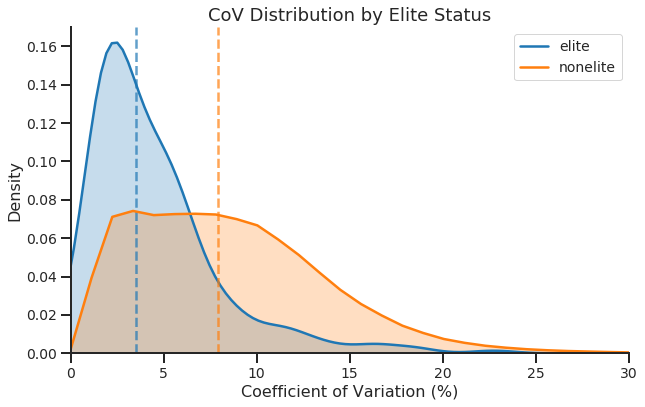

In [16]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['elite'] == 'elite']['cov'], label='elite', shade=True, color=blue)
plt.axvline(elt['cov'][0], color=blue, linestyle='dashed', alpha=.7)
sns.kdeplot(df[df['elite'] == 'nonelite']['cov'], label='nonelite', shade=True, color=orange)
plt.axvline(elt['cov'][1], color=orange, linestyle='dashed', alpha=.7)

plt.xlabel('Coefficient of Variation (%)')
plt.xlim((0,30))
plt.ylabel('Density')
plt.title('CoV Distribution by Elite Status')  
plt.savefig('img/cov/cov_distr_elite.png')
plt.show()


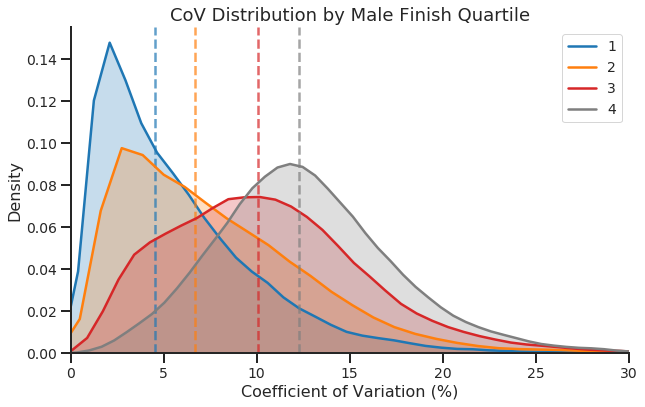

In [17]:
# distribution of CoV based on runner finish quartile

quart = df[df['gender']=='M'].groupby(['quartile'])['cov', 'split_Finish'].median()


plt.figure(figsize=(10,6))
for q in [1,2,3,4]:
    sns.kdeplot(df[(df['quartile'] == q) & (df['gender']=='M')]['cov'], label=q, shade=True, color=colors[q-1])
    plt.axvline(quart['cov'][q], color=colors[q-1], linestyle='dashed', alpha=.7)
plt.xlabel('Coefficient of Variation (%)')



plt.xlim((0,30))
plt.ylabel('Density')
plt.title('CoV Distribution by Male Finish Quartile')   
plt.savefig('img/cov/cov_distr_quartile_M.png')
plt.show()

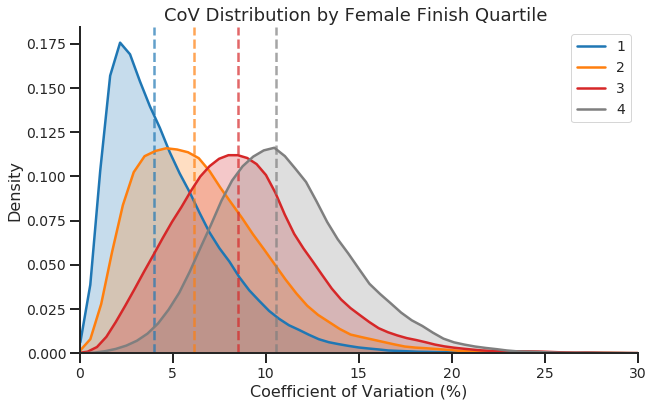

In [18]:
# distribution of CoV based on runner finish quartile
quart2 = df[df['gender']=='F'].groupby(['quartile'])['cov', 'split_Finish'].median()
plt.figure(figsize=(10,6))
for q in [1,2,3,4]:
    sns.kdeplot(df[(df['quartile'] == q) & (df['gender'] == 'F')]['cov'], label=q, shade=True, color=colors[q-1])
    plt.axvline(quart2['cov'][q], color=colors[q-1], linestyle='dashed', alpha=.7)
plt.xlabel('Coefficient of Variation (%)')



plt.xlim((0,30))
plt.ylabel('Density')
plt.title('CoV Distribution by Female Finish Quartile ')   
plt.savefig('img/cov/cov_distr_quartile_F.png')
plt.show()

In [19]:
rep = df.groupby(['repeat'])['cov'].median()
rep[0]

7.749489561985616

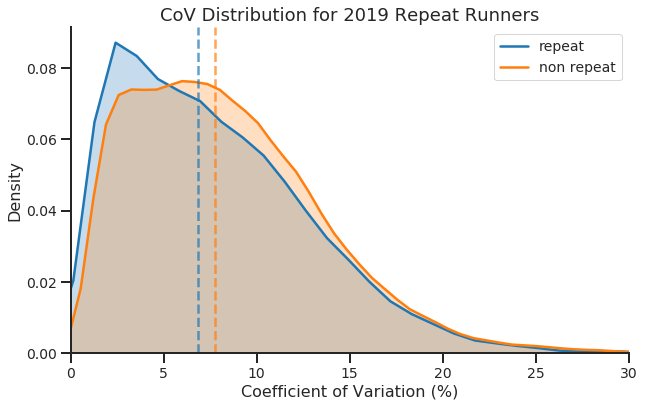

In [20]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['repeat'] == True]['cov'], label='repeat', shade=True)
plt.axvline(rep[0], color=orange, linestyle='dashed', alpha=.7)
sns.kdeplot(df[df['repeat'] == False]['cov'], label='non repeat', shade=True)
plt.axvline(rep[1], color=blue, linestyle='dashed', alpha=.7)



plt.xlabel('Coefficient of Variation (%)')
plt.xlim((0,30))
plt.ylabel('Density')
plt.title('CoV Distribution for 2019 Repeat Runners')  
plt.savefig('img/cov/cov_distr_repeat.png')
plt.show()



In [21]:
gend = df.groupby(['gender'])['cov'].median()
gend

gender
F    7.301975
M    8.485626
Name: cov, dtype: float64

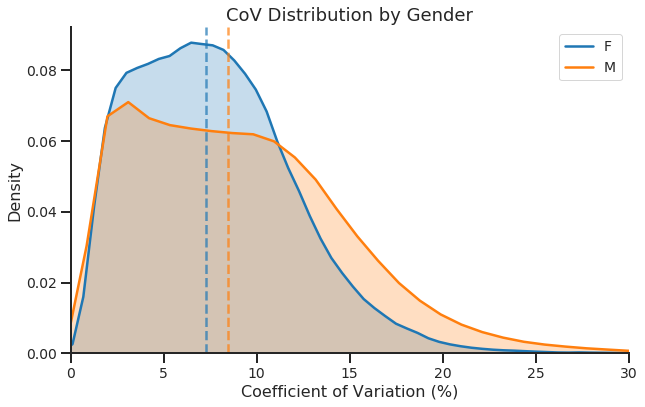

In [22]:
# distribution of CoV based on runner finish quartile
plt.figure(figsize=(10,6))
for g in ['F', 'M']:
    sns.kdeplot(df[df['gender'] == g]['cov'], label=g, shade=True)


plt.axvline(gend[0], color=blue, linestyle='dashed', alpha=.7)
plt.axvline(gend[1], color=orange, linestyle='dashed', alpha=.7)

plt.xlabel('Coefficient of Variation (%)')
plt.xlim((0,30))
plt.ylabel('Density')
plt.title('CoV Distribution by Gender')   
plt.savefig('img/cov/cov_distr_gender.png')
plt.show()

In [23]:
# women tend to have a smaller CoV 
# note that we divide by mean finish time, which on average is higher for women (thus CoV ends up being smaller)
# however this behavior is justified, since if a faster and slower runner had the same stdev, the faster
# runner would have a higher variation in pace

med = df['cov'].median()

print(f'median cov {med}')
df['consistent'] = df['cov'] < med

top25 = df['cov'].quantile(.25)
df['consistent_top25'] = df['cov'] < top25

median cov 7.929018929980025


In [24]:
# can see that consistent split runners average faster times - roughly 50 minutes faster!

df.groupby(['elite', 'gender', 'consistent'])['split_Finish'].mean()

# stratify by finish group (probably just do top 25, top 50, top 75, top 100 in M/F separately)


elite     gender  consistent
elite     F       False          9091.166667
                  True           8901.990291
          M       False          8487.160000
                  True           7923.753968
nonelite  F       False         19270.562741
                  True          15961.883288
          M       False         16837.863338
                  True          13690.109991
Name: split_Finish, dtype: float64

In [25]:
df.groupby(['gender'])['split_Finish', 'cov'].median()

,split_Finish,cov
gender,,
F,17210.0,7.301975
M,15093.0,8.485626


In [26]:
cat = df.groupby(['gender', 'category'])['split_Finish', 'cov'].mean()
#cat['split_Finish'] = split_format(cat, names=['split_Finish'], multi=False)
# convert to minutes
cat['split_Finish'] = cat['split_Finish']/60
cat.reset_index(inplace=True)
cat

,gender,category,split_Finish,cov
0,F,18-39,290.754072,7.938294
1,F,40-44,285.816229,7.229532
2,F,45-49,287.978681,7.333309
3,F,50-54,292.136126,7.616554
4,F,55-59,300.427383,7.890839
5,F,60-64,302.642850,7.790567
6,F,65-69,316.682642,8.005463
7,F,70+,335.485836,8.419977
8,M,18-39,255.325074,9.580358
9,M,40-44,249.684925,8.558817


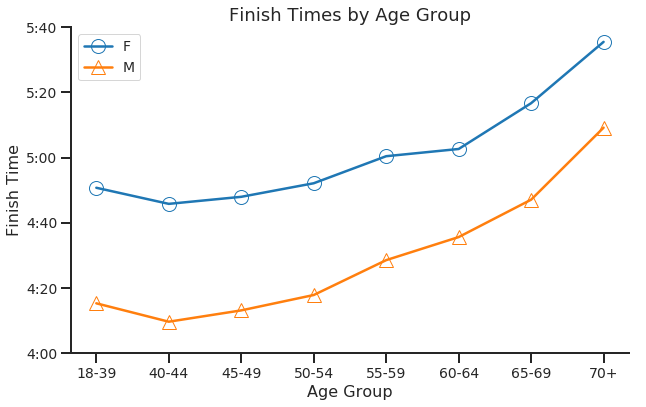

In [27]:
# note: catplot returns a facetgrid object, which needs to be manipulated in the following way (different from plt)
# ax = sns.catplot(data=cat, x="category", y="split_Finish", hue='gender', 
#             linestyles=["-", "-"], kind="point", 
#             hue_order = ['F', 'M'],legend_out=False)
# ax.set(yticks=np.arange(240, 360, 20))
# ax.set(yticklabels=['4:00', '4:20', '4:40', '5:00', '5:20', '5:40'])
# ax.fig.set_size_inches(10,6)

# ax.set(xlabel='Age Group', ylabel='Finish Time', title='Finish Times by Age Group')
# ax.fig.savefig('img/finish_by_age.png')

df1=cat[cat['gender']=='F']
df2=cat[cat['gender']=='M']
plt.figure(figsize=(10,6))
plt.plot('category', 'split_Finish', marker='o', color='C0', label='F', data=df1)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M', data=df2)

plt.legend()
plt.yticks(np.arange(240, 360, 20),
           labels=['4:00', '4:20', '4:40', '5:00', '5:20', '5:40'])
plt.ylabel('Finish Time')
plt.xlabel('Age Group')
plt.title('Finish Times by Age Group')
plt.savefig('img/desc/finish_times_by_age_group.png')
plt.show()


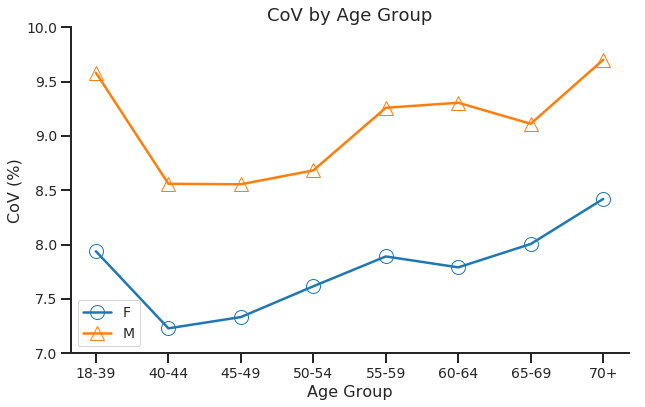

In [28]:
# ax = sns.catplot(data=cat, x="category", y="cov", hue='gender', 
#             linestyles=["-", "-"], kind="point", 
#             hue_order = ['F', 'M'], legend_out=False)

# ax.set(xlabel='Age Group', ylabel='CoV (%)', title='Consistency by Age Group')
# ax.fig.set_size_inches(10,6)
# ax.fig.savefig('img/cov_by_age.png')

# question: are females statistically more consistent?

plt.figure(figsize=(10,6))
plt.plot('category', 'cov', marker='o', color='C0', label='F', 
            data=df1)
plt.plot('category', 'cov', marker='^', color='C1', label='M',
            data=df2)

plt.legend()
plt.yticks(np.arange(7, 10.5, .5))
plt.ylabel('CoV (%)')
plt.xlabel('Age Group')
plt.title('CoV by Age Group')
plt.savefig('img/cov/cov_by_age_group.png')
plt.show()


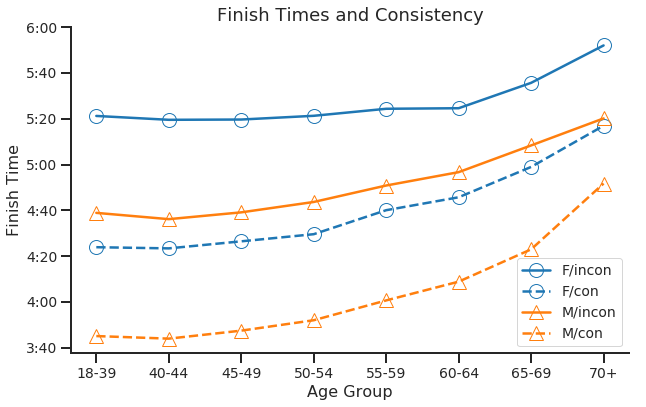

In [29]:
# same plot but with standard matplotlib 

temp = df.groupby(['gender', 'category', 'consistent'])['split_Finish'].mean()/60
temp = temp.reset_index()

df1 = temp[(temp['gender'] == 'F')& (temp['consistent'] == False)]
df2 = temp[(temp['gender'] == 'F')& (temp['consistent'] == True)]
df3 = temp[(temp['gender'] == 'M')& (temp['consistent'] == False)]
df4 = temp[(temp['gender'] == 'M')& (temp['consistent'] == True)]

plt.figure(figsize=(10,6))

plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/incon', 
            data=df1)
plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/con', 
         linestyle='dashed', data=df2)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M/incon', 
         data=df3)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M/con', 
         linestyle='dashed', data=df4)

plt.legend()

plt.yticks(np.arange(220, 380, 20),labels=['3:40', '4:00', '4:20', '4:40', '5:00', '5:20', '5:40', '6:00'])
plt.ylabel('Finish Time')
plt.xlabel('Age Group')
plt.title('Finish Times and Consistency')

plt.savefig('img/cov/finish_by_age_cov.png')
plt.show()

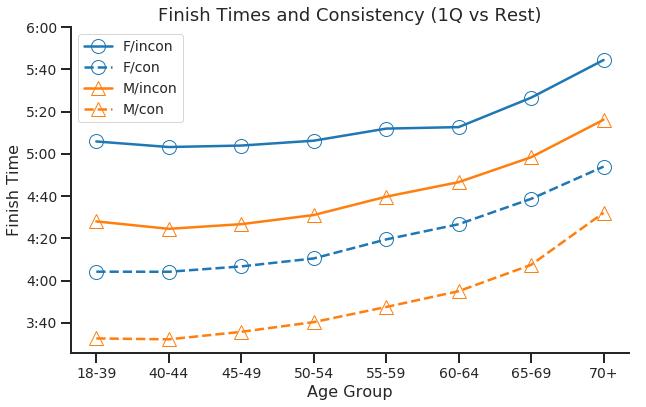

In [30]:
# same plot but with standard matplotlib 

temp = df.groupby(['gender', 'category', 'consistent_top25'])['split_Finish'].mean()/60
temp = temp.reset_index()

df1 = temp[(temp['gender'] == 'F')& (temp['consistent_top25'] == False)]
df2 = temp[(temp['gender'] == 'F')& (temp['consistent_top25'] == True)]
df3 = temp[(temp['gender'] == 'M')& (temp['consistent_top25'] == False)]
df4 = temp[(temp['gender'] == 'M')& (temp['consistent_top25'] == True)]

plt.figure(figsize=(10,6))

plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/incon', 
            data=df1)
plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/con', 
         linestyle='dashed', data=df2)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M/incon', 
         data=df3)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M/con', 
         linestyle='dashed', data=df4)

plt.legend()

plt.yticks(np.arange(220, 380, 20),labels=['3:40', '4:00', '4:20', '4:40', '5:00', '5:20', '5:40', '6:00'])
plt.ylabel('Finish Time')
plt.xlabel('Age Group')
plt.title('Finish Times and Consistency (1Q vs Rest)')

plt.savefig('img/cov/finish_by_age_cov25.png')
plt.show()

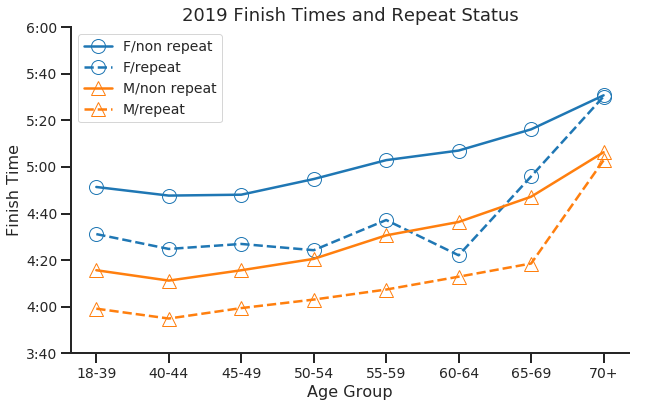

In [31]:
temp = df[df['year']==2019].groupby(['gender', 'category', 'repeat'])['split_Finish'].mean()/60
temp = temp.reset_index()
# same plot but with standard matplotlib 
plt.figure(figsize=(10,6))
df1 = temp[(temp['gender']=='F') & (temp['repeat']==False)] 
df2 = temp[(temp['gender']=='F') & (temp['repeat']==True)] 
df3 = temp[(temp['gender']=='M') & (temp['repeat']==False)] 
df4 = temp[(temp['gender']=='M') & (temp['repeat']==True)] 

plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/non repeat', 
            data=df1)
plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/repeat', 
         linestyle='dashed', data=df2)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M/non repeat', 
         data=df3)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M/repeat', 
         linestyle='dashed', data=df4)

plt.legend()

plt.yticks(np.arange(220, 380, 20),labels=['3:40', '4:00', '4:20', '4:40', '5:00', '5:20', '5:40', '6:00'])
plt.ylabel('Finish Time')
plt.xlabel('Age Group')
plt.title('2019 Finish Times and Repeat Status')

plt.savefig('img/desc/finish_by_age_repeat.png')
plt.show()

In [32]:
temp = df[df['year']==2019].groupby(['gender','repeat'])['split_Finish'].mean()/60
temp

gender  repeat
F       0.0       291.772756
        1.0       270.011953
M       0.0       257.837433
        1.0       240.565562
Name: split_Finish, dtype: float64

In [33]:
df[(df['gender']=='F') & (df['repeat']==True) & (df['category']=='55-59')]['split_Finish'].mean()

16632.439655172413

In [34]:
df[(df['gender']=='F') & (df['repeat']==True) & (df['category']=='60-64')]['split_Finish'].mean()

15723.471698113208

In [35]:
df[(df['gender']=='F') & (df['repeat']==True) & (df['category']=='65-69')]['split_Finish'].mean()

17755.914285714287

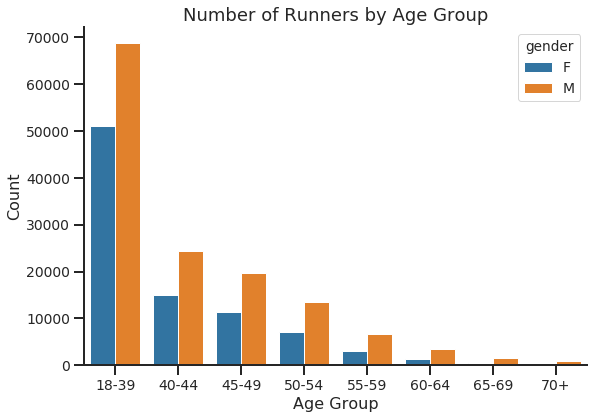

In [36]:
ct = df.groupby(['gender', 'category'])['name'].count()
ct = ct.reset_index()

g = sns.catplot(data=ct, x="category", y="name", hue='gender', 
             kind="bar", 
            hue_order = ['F', 'M'], legend_out=False)

g.set(xlabel='Age Group')
g.set(ylabel='Count')
g.set(title='Number of Runners by Age Group')
g.fig.set_size_inches(10,6)
g.fig.savefig('img/desc/count_by_age.png')

In [37]:
df.groupby(['category'])['category'].count()/df.shape[0]

category
18-39    0.524515
40-44    0.172209
45-49    0.135902
50-54    0.089901
55-59    0.042193
60-64    0.020736
65-69    0.008932
70+      0.005418
Name: category, dtype: float64

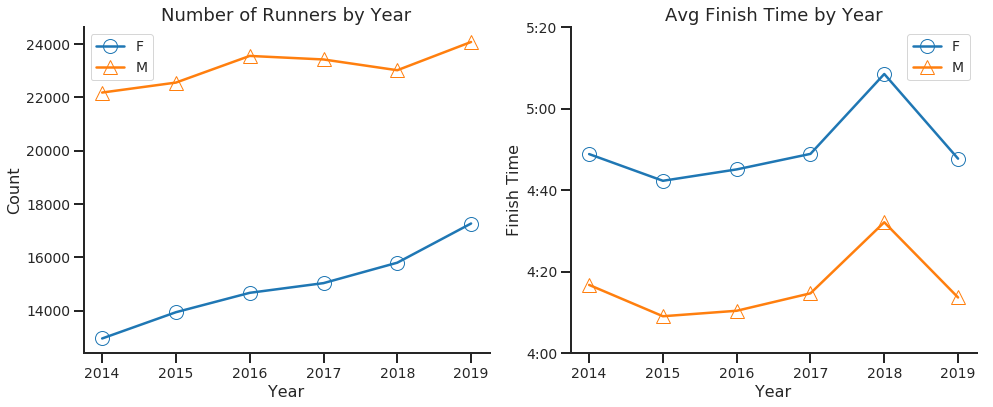

In [38]:
# analyze average finish times by year for both genders

by_year = df.groupby(['year', 'gender'])['split_Finish'].agg(['count', 'mean'])
by_year = by_year.reset_index()
by_year['year'] = by_year['year'].astype('str')
by_year['split_Finish_min'] = by_year['mean'] /60

df1 = by_year[by_year['gender']=='F']
df2 = by_year[by_year['gender']=='M']


fig, ax = plt.subplots(1, 2, figsize=(16,6))



ax[0].plot('year', 'count', marker='o', label='F', data=df1)
ax[0].plot('year', 'count', marker='^', label='M', data=df2)
ax[0].set_title('Number of Runners by Year')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].legend()

# annotate with peak temp?
#  9, 9, 14, 23, 16? 

ax[1].plot('year', 'split_Finish_min', marker='o', label='F', data=df1)
ax[1].plot('year', 'split_Finish_min', marker='^', label='M', data=df2)
ax[1].set_title('Avg Finish Time by Year')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Finish Time')
ax[1].set_yticks(np.arange(240, 340, 20))
ax[1].set_yticklabels(['4:00', '4:20', '4:40', '5:00', '5:20'])
ax[1].legend()

plt.savefig('img/desc/by_year.png')
plt.show()


# Negative Split Analysis

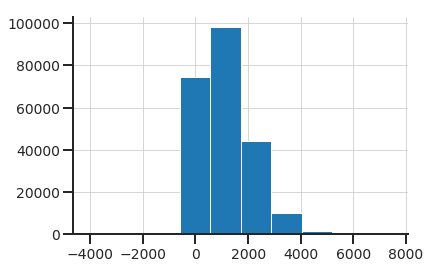

In [39]:
# common wisdom says negative splits are best
# omit 2018 data due to extreme heat

df['split_delta'] = (df['split_Half2']-df['split_Half'])
df['split_perc'] = df['split_delta']/df['split_Finish']*100
df['split_delta'].hist()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


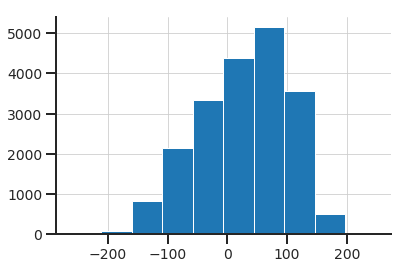

In [40]:
# categorizing runners as neg, even, pos based on split_perc
df['split_type'] = 'pos'
df.loc[df['split_perc'] <= -1, 'split_type'] = 'neg'

cond = (df['split_perc'] < 1) & (df['split_perc'] > -1)
df.loc[cond, 'split_type'] = 'even'


even = df[cond]
even['half/half2p'] = 1 - (df['split_Half']/df['split_Half2'])
even['split_delta'].hist()



# separate into 2 frames, one excluding 2018 since hot weather

splits = df.loc[df['year'] != 2018, ['name', 'year', 'gender', 'elite', 'category', 'quartile', 
                   'place_gender', 'place_category', 'cov', 'split_Half', 'split_Half2', 
                   'split_Finish', 'split_delta', 'split_perc', 'split_type']]


n = splits.shape[0]

In [41]:


# what percent of runners ran a true negative split? 
n_neg = splits[splits['split_delta']<=0].shape[0]
n_pos = splits[splits['split_delta']>0].shape[0]
perc_neg = n_neg/n_pos*100
print(perc_neg) 

6.054963795465347


In [42]:
# uncomment to run, takes >1 min

# splits['split_Half_min'] = splits['split_Half']/60
# splits['split_Half2_min'] = splits['split_Half2']/60

# plt.figure(figsize=(10,6))
# sns.kdeplot(splits['split_Half_min'], splits['split_Half2_min'],cmap="Reds", shade=True, bw=.15, shade_lowest=False,  legend=True)
# x = np.linspace(0,250,250)
# plt.plot(x, x, color='C0')
# plt.xlim((60,250))
# plt.ylim((60,250))
# plt.xticks(np.arange(60, 250, 30))
# plt.yticks(np.arange(60, 250, 30))
# plt.annotate('Negative', (175, 125), fontsize=14)
# plt.annotate('Positive', (75, 180), fontsize=14)
# plt.xlabel('Half1 Split (min)')
# plt.ylabel('Half2 Split (min)')
# plt.title('Half1 Split vs Half2 Split')
# plt.savefig('img/split/negsplit_contour.png')

In [43]:
splits.groupby(['elite', 'split_type'])['split_type'].count() / splits.groupby(['elite'])['name'].count()

elite     split_type
elite     even          0.240175
          neg           0.030568
          pos           0.729258
nonelite  even          0.101349
          neg           0.021220
          pos           0.877431
dtype: float64

In [44]:
splitnum = splits.groupby(['split_type'])['split_type'].count()/n*100
splitnum = np.round(splitnum).astype('int64')
splitnum

split_type
even    10
neg      2
pos     88
Name: split_type, dtype: int64

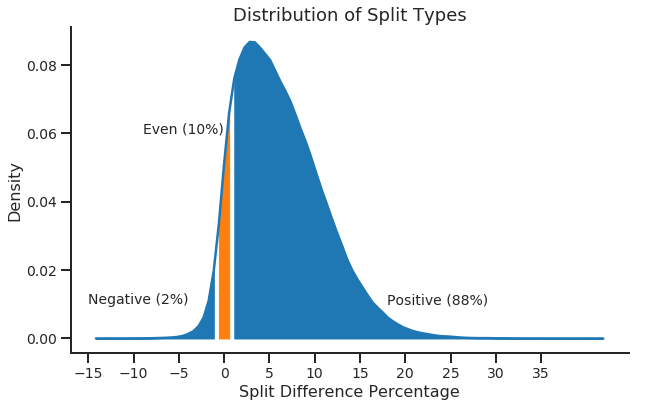

In [45]:
plt.figure(figsize=(10,6))

points = sns.kdeplot(splits['split_perc'], legend=False).get_lines()[0].get_data()

x = points[0]
y = points[1]

plt.fill_between(x,y, where = x <= -1, color='C0')
plt.fill_between(x,y, where = (x<=1) & (x>=-1), color='C1')
plt.fill_between(x,y, where = x >= 1, color='C0')
plt.xticks([-15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35])


plt.annotate(f'Even ({splitnum[0]}%)', (-9, .06), fontsize=14)
plt.annotate(f'Negative ({splitnum[1]}%)', (-15, .01), fontsize=14)
plt.annotate(f'Positive ({splitnum[2]}%)', (18, .01), fontsize=14)

plt.xlabel('Split Difference Percentage')
plt.ylabel('Density')
plt.title('Distribution of Split Types')
plt.savefig('img/split/split_type_distr.png')
plt.show()


In [46]:
nums = splits.groupby(['gender'])['name'].count()
t = splits.groupby(['gender', 'split_type'])['split_Finish'].count() / splits.groupby(['gender'])['split_Finish'].count()

#account for finish time. we split men and women into 4 quartiles (1,2,3,4) for each year.
# we then group by gender, quartile, split_type
t

gender  split_type
F       even          0.096427
        neg           0.020905
        pos           0.882668
M       even          0.104762
        neg           0.021439
        pos           0.873799
Name: split_Finish, dtype: float64

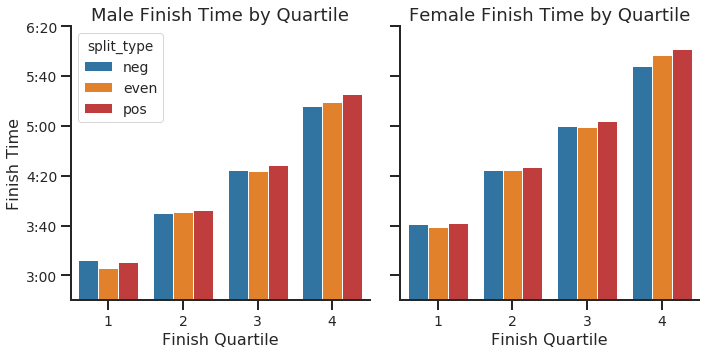

In [47]:
split_type_cat = splits.groupby(['gender', 'quartile', 'split_type'])['split_Finish'].mean()
split_type_cat = split_type_cat.reset_index()
split_type_cat['split_Finish'] = split_type_cat['split_Finish']/60
ax = sns.catplot(data=split_type_cat, x='quartile', y='split_Finish', hue='split_type', 
                 hue_order=['neg', 'even', 'pos'],
                 palette=['C0', 'C1', 'C3'], 
                 col='gender', 
                 col_order=['M','F'], 
                 kind='bar', legend_out=False)

ax.set(ylim=(160,360))
ax.set(yticks=np.arange(180, 420, 40))
ax.set(yticklabels=['3:00', '3:40', '4:20', '5:00', '5:40', '6:20'])

ax = ax.axes.flatten()
ax[0].set(title='Male Finish Time by Quartile')
ax[1].set(title='Female Finish Time by Quartile')
ax[0].set(ylabel='Finish Time')
ax[1].set(xlabel='Finish Quartile')
ax[0].set(xlabel='Finish Quartile')

plt.savefig('img/split/split_type_quartile.png')

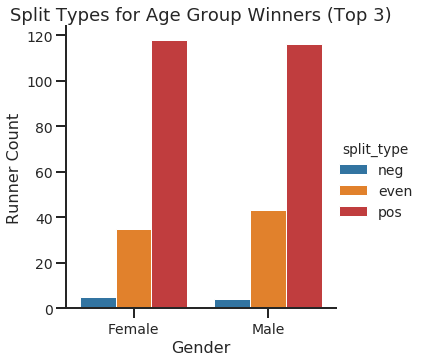

In [48]:
# pacing strategies of top3 age group placers (M/F)

ag_splits = splits[splits['place_category']<=3].groupby(['gender', 'split_type']).count()
#ag_splits = ag_splits.reset_index()
ag_splits['count'] = ag_splits['name']
ag_splits = ag_splits['count'].reset_index()
ax = sns.catplot(data=ag_splits, x='gender', y='count', hue='split_type', 
                 hue_order=['neg', 'even', 'pos'],
                 palette=['C0', 'C1', 'C3'],
                 kind='bar')
ax.set(xticklabels=['Female','Male'])
ax.set(xlabel='Gender')
ax.set(ylabel='Runner Count')
ax.set(title='Split Types for Age Group Winners (Top 3)')

plt.savefig('img/split/split_type_agegroupwinner.png')

In [49]:
# what about the winners?

df.groupby(['year', 'gender']).first()



index               name country  club category           id  \
year gender                                                                  
2014 F       115480     kiplagat, edna     KEN  None    18-39  10499992014   
     M       115504    kipsang, wilson     KEN  None    18-39    299992014   
2015 F       209886       tufa, tigist     ETH  None    18-39  10999992015   
     M       115478    kipchoge, eliud     KEN  None    18-39    499992015   
2016 F       200479    sumgong, jemima     KEN  None    18-39  10899992016   
     M       115477    kipchoge, eliud     KEN  None    18-39    199992016   
2017 F       110862      keitany, mary     KEN  None    18-39  10299992017   
     M       214085    wanjiru, daniel     KEN  None    18-39    699992017   
2018 F        30571  cheruiyot, vivian     KEN  None    18-39  10999992018   
     M       110918    kipchoge, eliud     KEN  None    18-39    399992018   
2019 F       110991     kosgei, brigid     KEN     –    18-39          105   
     M       110919    kipchoge, eliud     KEN     –    18-39            1   

             place_gender  place_category  place_overall  elite  split_5K  \
year gender                                                                 
2014 F                  1               1             18  elite    1006.0   
     M                  1               1              1  elite     862.0   
2015 F                  1               1             21  elite    1014.0   
     M                  1               1              1  elite     872.0   
2016 F                  1               1             26  elite     991.0   
     M                  1               1              1  elite     856.0   
2017 F                  1               1             20  elite     931.0   
     M                  1               1              1  elite     852.0   
2018 F                  1               1             15  elite     975.0   
     M                  1               1              1  elite     828.0   
2019 F                  1               1             32  elite    1018.0   
     M                  1               1              1  elite     863.0   

             split_5K_diff  split_10K  split_10K_diff  split_15K  \
year gender                                                        
2014 F              1006.0     1968.0           963.0     2946.0   
     M               862.0     1752.0           891.0     2646.0   
2015 F              1014.0     2002.0           988.0     3053.0   
     M               872.0     1755.0           884.0     2644.0   
2016 F               991.0     1963.0           973.0     3005.0   
     M               856.0     1717.0           861.0     2597.0   
2017 F               931.0     1877.0           947.0     2835.0   
     M               852.0     1732.0           880.0     2621.0   
2018 F               975.0     1973.0           998.0     2958.0   
     M               828.0     1699.0           871.0     2585.0   
2019 F              1018.0     2023.0          1005.0     3058.0   
     M               863.0     1741.0           879.0     2622.0   

             split_15K_diff  split_20K  split_20K_diff  split_Half  \
year gender                                                          
2014 F                979.0     3939.0           993.0      4157.0   
     M                895.0     3555.0           909.0      3751.0   
2015 F               1051.0     4086.0          1034.0      4303.0   
     M                890.0     3541.0           897.0      3740.0   
2016 F               1042.0     4024.0          1019.0      4245.0   
     M                881.0     3490.0           894.0      3684.0   
2017 F                959.0     3806.0           971.0      4014.0   
     M                889.0     3511.0           891.0      3703.0   
2018 F                985.0     3931.0           974.0      4136.0   
     M                887.0     3472.0           888.0      3660.0   
2019 F               1036.0     4093.0          1

In [62]:
.05/25

0.002

In [59]:
# test whether females are significantly more consistent than males

a = df.loc[df['gender']=='F', 'cov']
b = df.loc[df['gender']=='M', 'cov']
t, p = stats.ttest_ind(a,b, equal_var=False)
print(g, q, t, p, p/2 < .001)

M 4 -68.2625608449907 0.0 True


In [60]:
# testing whether consistent runners are faster, stratified by gender and finish quartile

gqc = df.groupby(['gender', 'quartile', 'consistent'])['split_Finish'].agg(['mean', 'std', 'count'])
gqc = gqc.reset_index()
gqc 

# do 1 sided t test w/ bonferonni (combined, we run 16 tests)
# consider using Tukey HSD (to address multiple comparisons)
for g in ['F', 'M']:
    for q in [1,2,3,4]:
        temp = df[(df['gender']==g) & (df['quartile']==q)]
        a = temp[temp['consistent']==True]['split_Finish']
        b = temp[temp['consistent']==False]['split_Finish']

        t, p = stats.ttest_ind(a,b, equal_var=False)
        print(g, q, t, p, p/2 < .001)
        
# significant at <.003 for every group except F 4



signif  0.003125
F 1 -30.22902033559645 2.3135255466899517e-183 True
F 2 -33.52925127188373 6.0972829878206445e-236 True
F 3 -45.472333155258646 0.0 True
F 4 0.13351802088308198 0.8937880469787769 False
M 1 -54.284502698324665 0.0 True
M 2 -42.85130823981971 0.0 True
M 3 -47.37371123350793 0.0 True
M 4 -23.80463680228005 1.5222598197646458e-120 True


In [61]:
# testing whether even split runners are faster, stratified by gender and finish quartile
df['even'] = False
df.loc[df['split_type'] == 'even', 'even'] = True

for g in ['F', 'M']:
    for q in [1,2,3,4]:
        temp = df[(df['gender']==g) & (df['quartile']==q)]
        a = temp[temp['even']==True]['split_Finish']
        b = temp[temp['even']==False]['split_Finish']
        t, p = stats.ttest_ind(a,b, equal_var=False)
        print(g, q, t, p, p/2 < .001)       
# under same analysis, even splits are significantly faster than noneven

signif  0.003125
F 1 -19.28383003859012 1.4993649201483248e-80 True
F 2 -20.059315354019116 2.2183652751996133e-83 True
F 3 -18.06900472657468 1.45008639058065e-63 True
F 4 -4.406965060857724 1.3535307785253623e-05 True
M 1 -27.176847153109158 3.793345911913312e-157 True
M 2 -31.78666914861502 2.63161605118387e-205 True
M 3 -23.410601912271954 1.3802340361798385e-103 True
M 4 -4.906272193936609 1.352471289084061e-06 True


In [65]:
# testing whether even split runners are faster than neg split runners

for g in ['F', 'M']:
    for q in [1,2,3,4]:
        temp = df[(df['gender']==g) & (df['quartile']==q)]
        a = temp[temp['split_type']=='even']['split_Finish']
        b = temp[temp['split_type']=='neg']['split_Finish']
        t, p = stats.ttest_ind(a,b, equal_var=False)
        print(g, q, t, p, p/2 < .003)       
# under same analysis, even splits are significantly faster than noneven

F 1 -2.9077500381958474 0.0037290924816326255 True
F 2 -0.11372023894762932 0.9094918543472922 False
F 3 -1.322000269491821 0.18672274949735193 False
F 4 2.8659766256172343 0.004483417377914179 True
M 1 -12.607144922927406 1.3658808420264316e-34 True
M 2 0.5146894467203714 0.6068488999977608 False
M 3 -1.9074808957487561 0.05689873665439229 False
M 4 -0.027820292277475383 0.9778177880340347 False


Conclusions:

heat has a very high impact on finish times (so 2018 was excluded)

women are generally more consistent than men
stratified by gender and quartile, consistent runners are significantly faster
than those who are not (with the exception of the F 4 group)
across all age groups, 40-49 tend to be the most consistent and the fastest
across all age groups, consistent runners are faster


the vast majority of runners positive split (2/11/87)

elites are more likely to even split, but still prefer positive splits. distr is (23, 3, 72)
3/4 of eliud kipchoge's races were even split, with the one exception being 2018 pos split

men/women are roughly equally likely to even/pos/neg split
faster runners are more likely to even/neg split


in the first quartile of runners, even splits yielded the fastest finishes 
the vast majority of runners, elite or non elite, still positive split.
stratified by gender and quartile, even split runners are significantly faster than non even splits


In [54]:
# TODO: graph relative pace (current split pace / avg pace) by groups, also might be worth investigating % BQ as well 
# if I have extra time
# ok - this is kind of obv. what isn't obv? consistency by age group?
# finish times by age group?
# finish times by people who have >1 marathon in last 5 yrs?

# run a regression model for time projection?


In [55]:
# note that roughly 6k/240k runners had missing split data, so they were dropped
# since we are interested in pace variability, lack of split data = no good
# however we could potentially use them in the future as a test set if we 
# are interested in a time projection model

# con = sqlite3.connect('../nonelite.db')
# df.to_sql(name='complete2',con=con)
# con.close()